# Measuring Statistics about Information Sources in MIDI Files

A MIDI file can provide a cornucopia of musical information about a given piece of music, including transcription, key, lyrics, and meter.
However, the presence and quantity of each of these sources of information can vary.
Through a large-scale web scrape, we obtained 178,561 unique (i.e. having different MD5 checksums) MIDI files.
This notebook measures the availability of each possible source of information in MIDI files in this collection of MIDIs found "in the wild".

In [1]:
import pretty_midi
import numpy as np
import joblib
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
import matplotlib.gridspec
import collections
import os
# plotting.py contains utility functions for making nice histogram plots
import plotting

## Compute statistics

The `compute_statistics` function takes in a MIDI file and simply collects the number, and values for, different events (for example, key change values and tempo settings) in the file.
We will call this function for every entry in our 178,561 MIDI file collection and use these measurements to study the distributions of different event values and quantities of different event types.

In [2]:
def compute_statistics(midi_file):
    """
    Given a path to a MIDI file, compute a dictionary of statistics about it
    
    Parameters
    ----------
    midi_file : str
        Path to a MIDI file.
    
    Returns
    -------
    statistics : dict
        Dictionary reporting the values for different events in the file.
    """
    # Some MIDI files will raise Exceptions on loading, if they are invalid.
    # We just skip those.
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
        # Extract informative events from the MIDI file
        return {'n_instruments': len(pm.instruments),
                'program_numbers': [i.program for i in pm.instruments if not i.is_drum],
                'key_numbers': [k.key_number for k in pm.key_signature_changes],
                'tempos': list(pm.get_tempo_changes()[1]),
                'time_signature_changes': pm.time_signature_changes,
                'end_time': pm.get_end_time(),
                'lyrics': [l.text for l in pm.lyrics]}
    # Silently ignore exceptions for a clean presentation (sorry Python!)
    except Exception as e:
        pass

In [3]:
# Compute statistics about every file in our collection in parallel using joblib
# We do things in parallel because there are tons so it would otherwise take too long!
statistics = joblib.Parallel(n_jobs=10, verbose=0)(
    joblib.delayed(compute_statistics)(midi_file)
    for midi_file in glob.glob(os.path.join('data', 'lmd_full', '*', '*.mid')))
# When an error occurred, None will be returned; filter those out.
statistics = [s for s in statistics if s is not None]

## Length
To begin with, we can get an idea of the type of MIDI files which are available by looking at their length (i.e. time in seconds).  MIDI files are variously used for storing short melodic fragmets, drum patterns, ringtones, and full-song transcriptions; looking at the distribution of lengths of MIDI files in our collection gives a rough picture of how common each of these uses is.

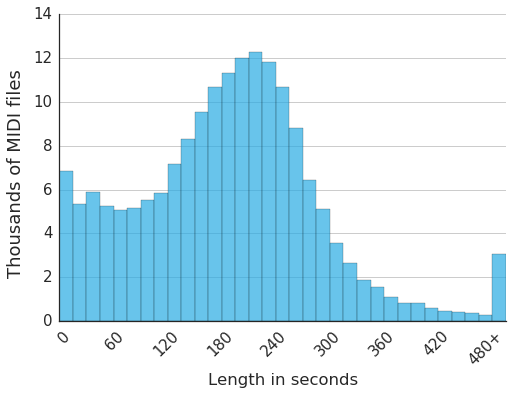

In [4]:
plotting.plot_hist([s['end_time'] for s in statistics], range(0, 500, 15),
                   'Length in seconds', 'Thousands of MIDI files')
plt.xticks(np.arange(0, len(range(0, 500, 15)), 4) + .5,
           range(0, 430, 60) + ['480+'], rotation=45, ha='right');

## Instruments
In their simplest form, MIDI files contain a collection of notes played on a collection of instruments.  Under the General MIDI specification, 128 instruments are available (see `pretty_midi.INSTRUMENT_MAP` for a list) which are indexed by their "program number".  The distribution of the number of instruments in our MIDI files gives us further intuition into the MIDI files' usage; the distribution of program numbers shows us which instruments are more or less popular.  The four most common program numbers (shown as the four tallest bars in the distribution of program numbers) were 0 (“Acoustic Grand Piano”), 48 (“String Ensemble 1”), 33 (“Electric Bass (finger)”), and 25 (“Acoustic Guitar (steel)”).

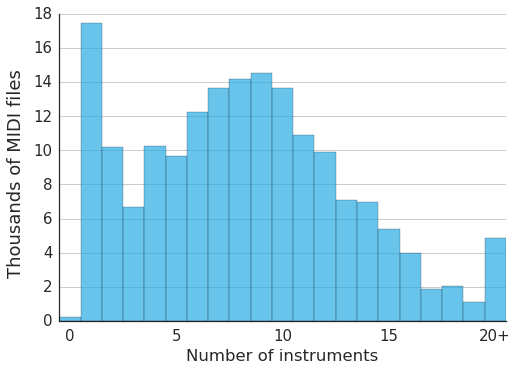

In [5]:
plotting.plot_hist([s['n_instruments'] for s in statistics], range(22),
                   'Number of instruments', 'Thousands of MIDI files')
plt.xticks(range(0, 22, 5), range(0, 22 - 5, 5) + ['20+']);

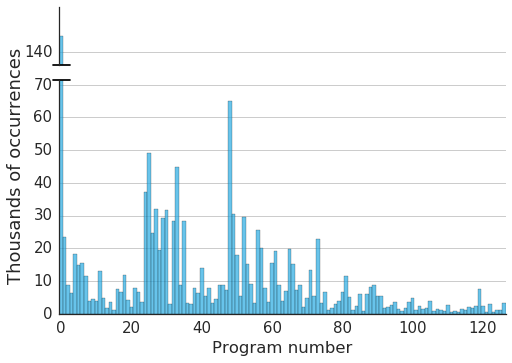

In [6]:
plotting.plot_hist([i for s in statistics for i in s['program_numbers']], range(128),
                   'Program number', 'Thousands of occurrences')

## Tempo changes
The timing of events in MIDI files is determined by tempo change events, which allow conversion from the MIDI "tick" timebase to absolute time in seconds.  Using many tempo change events can allow for a MIDI transcription's timing to closely match that of a specific performance of a piece of music.  While 120bpm is the default tempo for a MIDI file, the distribution of tempos shows that a wide variety of tempos is used.

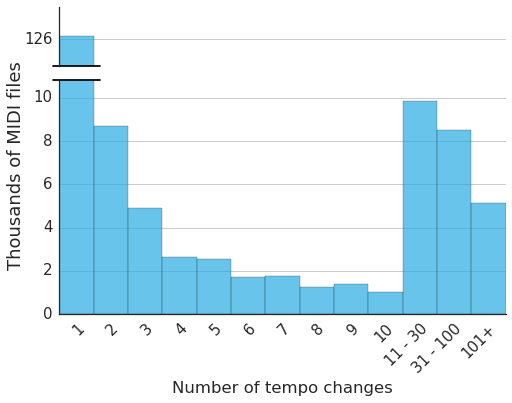

In [7]:
plotting.plot_hist([len(s['tempos']) for s in statistics], range(1, 12) + [30, 100, 1000],
                   'Number of tempo changes', 'Thousands of MIDI files')
plt.xticks(np.arange(13) + .3, range(1, 11) + ['11 - 30', '31 - 100', '101+'],
           rotation=45, ha='right');

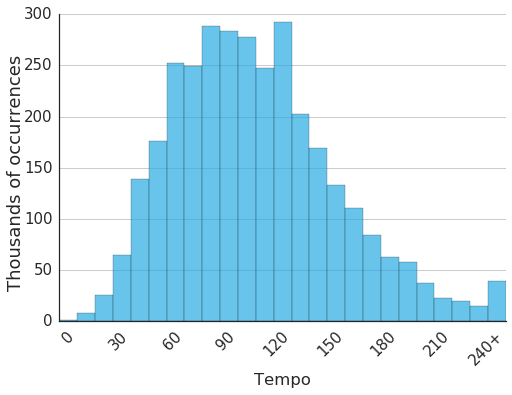

In [8]:
plotting.plot_hist([i for s in statistics for i in s['tempos']], range(0, 260, 10),
                   'Tempo', 'Thousands of occurrences')
plt.xticks(np.arange(0, len(range(0, 260, 10)), 3) + .5, range(0, 240, 30) + ['240+'],
           rotation=45, ha='right');

## Time signature changes
As their name suggests, time signature changes allow the time signature of the music to be specified.  Together with tempo change events, they allow the exact metrical structure (beats and downbeats) of a piece of music to be readily extracted.  The vast majority of MIDI files have a single time signature change event, and the vast majority of time signature changes are to 4/4, but there are nevertheless many examples in our collection with unusual metrical structure.

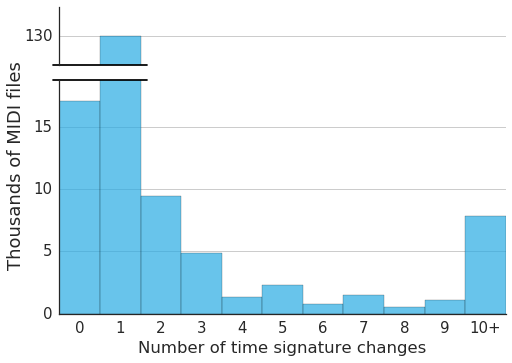

In [9]:
plotting.plot_hist([len(s['time_signature_changes']) for s in statistics], range(12),
                   'Number of time signature changes', 'Thousands of MIDI files')
plt.xticks(range(11), range(10) + ['10+']);

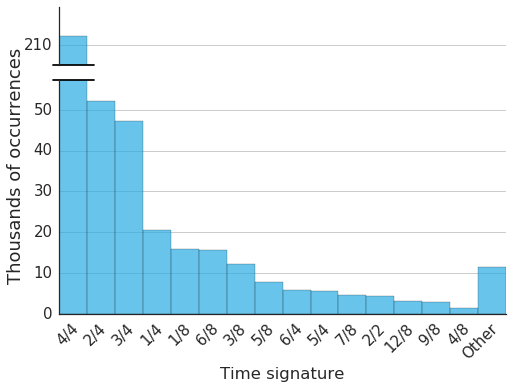

In [10]:
# Get strings for all time signatures
time_signatures = ['{}/{}'.format(c.numerator, c.denominator)
                   for s in statistics for c in s['time_signature_changes']]

# Only display the n_top top time signatures
n_top = 15
# Get the n_top top time signatures
top = collections.Counter(time_signatures).most_common(n_top)
# Create a dict mapping an integer index to the time signature string
top_signatures = {n: s[0] for n, s in enumerate(top)}
# Add an additional index for non-top signatures
top_signatures[n_top] = 'Other'
# Compute the number of non-top time signatures
n_other = len(time_signatures) - sum(s[1] for s in top)
# Create a list with each index repeated the number of times
# each time signature appears, to be passed to plt.hist
indexed_time_signatures = sum([[n]*s[1] for n, s in enumerate(top)], [])
indexed_time_signatures += [n_top]*n_other

plotting.plot_hist(indexed_time_signatures, range(n_top + 2),
                   'Time signature', 'Thousands of occurrences')
plt.xticks(np.array(top_signatures.keys()) + .3, top_signatures.values(),
           rotation=45, ha='right');

## Key changes
The current key in a piece of music can be specified with the optional key signature change meta-events.  These events do not affect playback, so many of our MIDI files omit these events altogether, though a roughly equal number had a single key change event.  Interestingly, a disproportionate number of MIDI files had a key change to C major - this is likely a reflection of the fact that many MIDI transcription software packages automatically insert a C major key change.

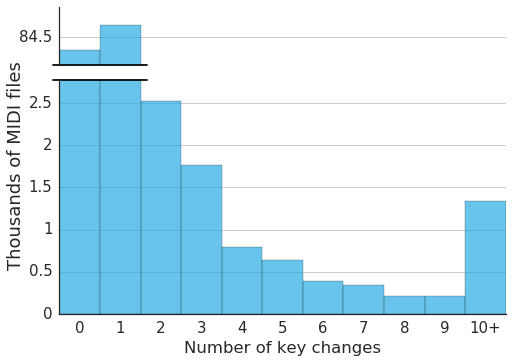

In [11]:
plotting.plot_hist([len(s['key_numbers']) for s in statistics], range(12),
                   'Number of key changes', 'Thousands of MIDI files')
plt.xticks(range(11), range(10) + ['10+']);

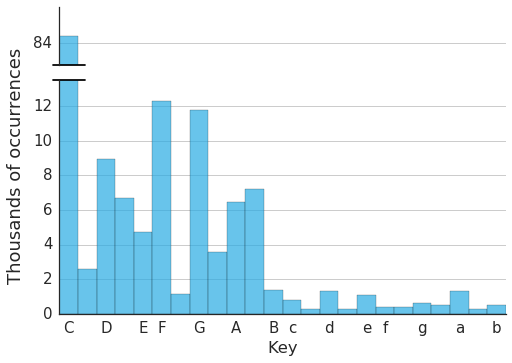

In [12]:
plotting.plot_hist([i for s in statistics for i in s['key_numbers']], range(25),
                   'Key', 'Thousands of occurrences')
plt.xticks([0, 2, 4, 5, 7, 9, 11, 12, 14, 16, 17, 19, 21, 23],
           ['C', 'D', 'E', 'F', 'G', 'A', 'B', 'c', 'd', 'e', 'f', 'g', 'a', 'b']);

## Lyrics
MIDI files can also optionally include timestamped lyrics events.  This in particular facilitates their use for karaoke.  In our collection, we found 23,801 MIDI files (about 13.3%) which had at least one lyrics meta-event.  Lyrics are often transcribed the word, syllable, or character level, as indicated by the distibution of the lengths of their text.  The preponderance of length-1 lyrics is also caused by characters (e.g. newlines and spaces) which indicate the end of a phrase.

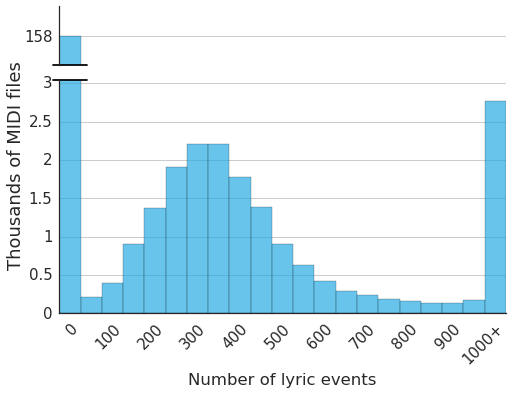

In [13]:
plotting.plot_hist([len(s['lyrics']) for s in statistics], range(0, 1060, 50),
                   'Number of lyric events', 'Thousands of MIDI files')
plt.xticks(np.arange(0, len(range(0, 1050, 50)), 2) + .5,
           range(0, 1000, 100) + ['1000+'], rotation=45, ha='right');

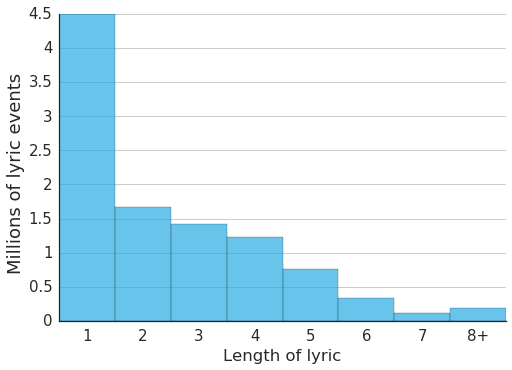

In [14]:
plotting.plot_hist([len(l) for s in statistics for l in s['lyrics']], range(1, 10),
                   'Length of lyric', 'Millions of lyric events', 1000000)
plt.xticks(range(0, 8), range(1, 8) + ['8+']);